In [316]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [317]:
df = pd.read_csv('../../data/kc_house_data.csv')
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [318]:
winsorize_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_percentile=0.01, upper_percentile=0.99):
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile

    def fit(self, X, y=None):
        self.lower_bounds = np.percentile(X, self.lower_percentile * 100, axis=0)
        self.upper_bounds = np.percentile(X, self.upper_percentile * 100, axis=0)
        return self

    def transform(self, X):
        return np.clip(X, self.lower_bounds, self.upper_bounds)

winsorizer = Winsorizer()
df[winsorize_features] = winsorizer.fit_transform(df[winsorize_features])

log_features = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
df[log_features] = np.log1p(df[log_features])

df['yr_renovated'] = (df['yr_renovated'] > 0).astype(int)

In [319]:
df.drop(['lat', 'long', 'id', 'date'], axis=1, inplace=True)
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
0,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.000000,1955,0,98178,7.201171,8.639588
1,13.195616,3,2.25,7.852050,8.887791,2.0,0,0,3,7,7.682943,5.993961,1951,1,98125,7.433075,8.941153
2,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.000000,1933,0,98028,7.908755,8.995041
3,13.311331,4,3.00,7.581210,8.517393,1.0,0,0,5,7,6.957497,6.814543,1965,0,98136,7.215975,8.517393
4,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.000000,1987,0,98074,7.496097,8.923191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,12.793862,3,2.50,7.333676,7.031741,3.0,0,0,3,8,7.333676,0.000000,2009,0,98103,7.333676,7.319865
21609,12.899222,4,2.50,7.745436,8.668024,2.0,0,0,3,8,7.745436,0.000000,2014,0,98146,7.512618,8.881975
21610,12.904461,2,1.00,6.928538,7.208600,2.0,0,0,3,7,6.928538,0.000000,2009,0,98144,6.928538,7.604894
21611,12.899222,3,2.50,7.378384,7.778630,2.0,0,0,3,8,7.378384,0.000000,2004,0,98027,7.252054,7.160846


In [320]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['price']), 
                                                    df.price,
                                                    test_size=0.3, 
                                                    random_state=23)

print(X_train.shape)

(15129, 16)


In [321]:
X_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
6138,3,1.00,6.928538,8.699681,1.5,0,0,3,7,6.928538,0.00000,1900,0,98108,7.123673,8.699681
498,2,1.50,7.307202,8.657129,1.5,0,0,4,7,7.082549,5.70711,1900,0,98116,7.372118,8.300529
20836,4,2.50,7.889834,8.591558,2.0,0,0,3,9,7.889834,0.00000,2014,0,98092,7.889834,8.443762
16908,3,1.75,7.433075,8.760296,1.0,0,0,3,8,7.433075,0.00000,1903,1,98024,7.147559,8.958669
3921,4,2.75,8.354910,9.298901,2.0,0,0,3,10,8.354910,0.00000,2003,0,98059,8.444838,9.354008


In [322]:
y_train.head()

6138     12.729324
498      13.345509
20836    12.905192
16908    13.032441
3921     14.004477
Name: price, dtype: float64

In [323]:
categorical_features_ordinal = ['bedrooms', 'floors', 'view', 'condition', 'grade']
numerical_features = ['bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'yr_built']

ordinal_categories = [
    sorted(df['bedrooms'].unique()), 
    sorted(df['floors'].unique()), 
    sorted(df['view'].unique()),
    sorted(df['condition'].unique()),
    sorted(df['grade'].unique())  
]

preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=ordinal_categories), categorical_features_ordinal),  # Ordinal Encoding
        ('num', Pipeline(steps=[
            ('winsorizer', Winsorizer()),  # Handle outliers
            ('log_transform', FunctionTransformer(np.log1p, validate=True)),  # Fix skewness
            ('scaler', StandardScaler())  # Standardize numerical features
        ]), numerical_features),
        ('zipcode', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['zipcode'])  # One-hot encode zipcode
    ]
)


In [324]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [325]:
X_train.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
count,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000
mean,3.375504,2.109046,7.548103,8.987961,1.490118,0.008130,0.241126,3.413577,7.651398,7.393716,2.525077,1970.868531,0.042369,98077.898605,7.537727,8.961402
std,0.863570,0.746900,0.415742,0.882155,0.538372,0.089803,0.778069,0.652014,1.172730,0.418199,3.167063,29.327070,0.201436,53.596178,0.327082,0.808210
min,2.000000,1.000000,6.580639,6.921777,1.000000,0.000000,0.000000,1.000000,3.000000,6.552508,0.000000,1900.000000,0.000000,98001.000000,5.991465,6.480045
25%,3.000000,1.750000,7.266129,8.525756,1.000000,0.000000,0.000000,3.000000,7.000000,7.082549,0.000000,1952.000000,0.000000,98033.000000,7.300473,8.537192
50%,3.000000,2.250000,7.550135,8.940236,1.500000,0.000000,0.000000,3.000000,7.000000,7.353082,0.000000,1974.000000,0.000000,98065.000000,7.512618,8.938925
75%,4.000000,2.500000,7.840313,9.275941,2.000000,0.000000,0.000000,4.000000,8.000000,7.696667,6.329721,1996.000000,0.000000,98118.000000,7.762596,9.220192
max,6.000000,4.250000,8.513145,12.269090,3.500000,1.000000,4.000000,5.000000,13.000000,8.382747,7.415175,2015.000000,1.000000,98199.000000,8.734077,13.677628


In [326]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ord',
                                                  OrdinalEncoder(categories=[[2,
                                                                              3,
                                                                              4,
                                                                              5,
                                                                              6],
                                                                             [1.0,
                                                                              1.5,
                                                                              2.0,
                                                                              2.5,
                                                                              3.0,
                                                                              3.5],
                                                                             [0,
                                                                              1,
                                                                              2,
                                                                              3,
                                                                              4],
                                                                             [1,
                                                                              2,
                                                                              3,
                                                                              4,
                                                                              5],
                                                                             [1,
                                                                              3,
                                                                              4,
                                                                              5,
                                                                              6,
                                                                              7,
                                                                              8,
                                                                              9,
                                                                              10,
                                                                              11,
                                                                              12,
                                                                              13]]),
                                                  ['bedrooms', 'floors', 'view',
                                                   'condition', 'grade']),
                                                 ('num',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer()),
                                                                  ('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       validate=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bathrooms', 'sqft_living',
                                                   'sqft_lot', 'sqft_above',
                                                   'sqft_basement',
                                                   'sqft_living15',
                                                   'sqft_lot15', 'yr_built']),
     

In [327]:
## IMPORTANT: Need to convert predictions back to original scale
y_pred = np.expm1(model_pipeline.predict(X_test))

In [328]:
y_test_original = np.expm1(y_test)

In [329]:
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2 = r2_score(y_test_original, y_pred)

In [330]:
rmse

137743.52627230136

In [331]:
r2

0.8454466097572442

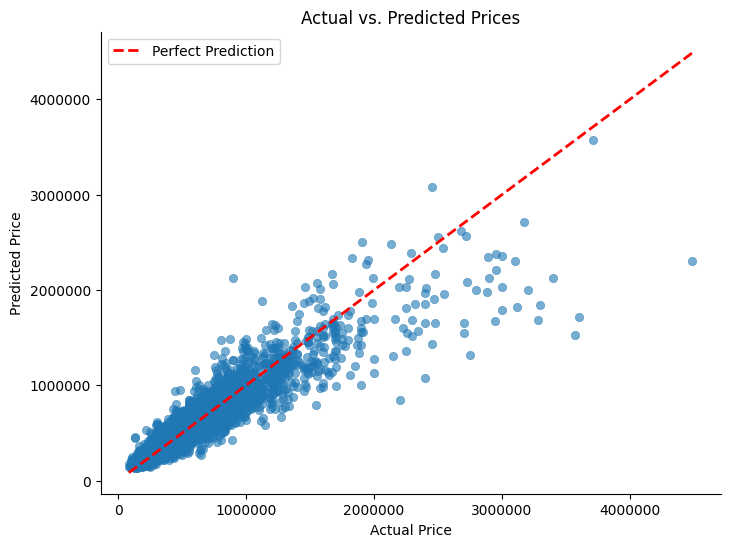

In [332]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_original, y=y_pred, alpha=0.6, edgecolor=None)

plt.plot([min(y_test_original), max(y_test_original)], 
         [min(y_test_original), max(y_test_original)], 
         color='red', linestyle='--', linewidth=2, label="Perfect Prediction")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Prices")

plt.ticklabel_format(style='plain', axis='both')  

sns.despine()
plt.legend()
plt.show()


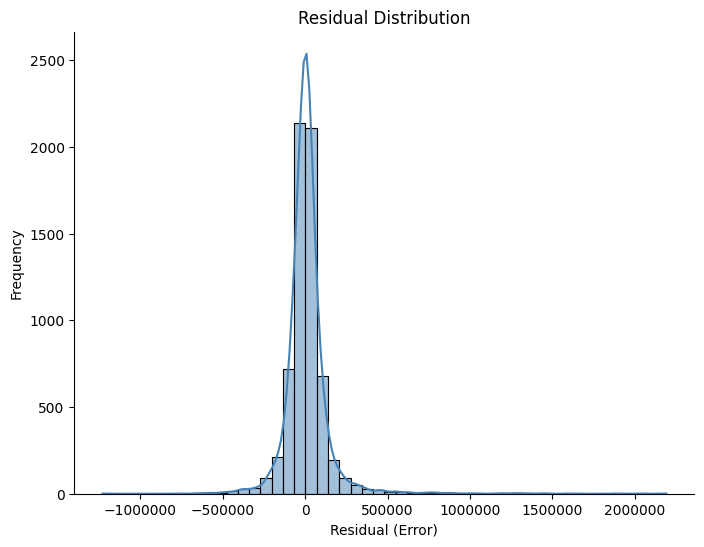

In [333]:
residuals = y_test_original - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True, color="steelblue")

plt.xlabel("Residual (Error)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")

plt.ticklabel_format(style='plain', axis='both')

sns.despine()
plt.show()
